In [19]:
# ───────────────────── 1. LIBRERÍAS ─────────────────────────────
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import matplotlib.colors as mcolors, matplotlib.cm as cm
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle, FancyArrowPatch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cartopy.crs as ccrs
from matplotlib import colormaps
from pathlib import Path
import matplotlib.ticker as mticker
from utils import decimal_to_datetime, norm_dep, bezier


In [20]:
# ───────────────────── 3. CARGA DE DATOS ───────────────────────
file = Path("../data/Fig3_AllPeru_RegionDateMovements.txt")
df   = pd.read_csv(file, sep="\t")

# fechas decimales → datetime
for col in ("ParentDate", "ChildDate"):
    df[col] = df[col].apply(decimal_to_datetime)

# normalización de nombres
for col in ("ParentRegion", "ChildRegion"):
    df[col] = df[col].apply(norm_dep)

# # Filtrar solo 1 ruta por mes
df['año'] = df['ParentDate'].dt.year
df['mes'] = df['ParentDate'].dt.month
df['trimestre'] = df['ParentDate'].dt.quarter
df = df.sort_values('ParentDate')  # ¡Muy importante!
# df = df.groupby(['ParentRegion', 'ChildRegion', 'año', 'mes']).head(1).reset_index()
df = df.groupby(['ParentRegion', 'ChildRegion', 'año']).head(1).reset_index()
# df['ruta_id'] = df.groupby(['ParentRegion', 'ChildRegion']).cumcount()
# print(f"Número de movimientos: {len(df)}")


In [21]:
# ───────────────────── 4. SHAPEFILE Y CENTROIDES ───────────────
shp = "../data/DEPARTAMENTOS_inei_geogpsperu_suyopomalia/DEPARTAMENTOS_inei_geogpsperu_suyopomalia.shp"
gdf = gpd.read_file(shp)
# 1.  Proyección métrica adecuada para Perú  ──────────
#    UTM zona 18 Sur (EPSG:32718) cubre la mayor parte del país.
gdf_m = gdf.to_crs("EPSG:32718")
# 2.  Centroides en metros  ───────────────────────────
centroids_xy = gdf_m.centroid            # punto (x, y) en metros
# 3.  De vuelta a lon/lat  ───────────────────────────
centroids_ll = centroids_xy.to_crs("EPSG:4326")   # WGS-84

gdf["NOMBDEP"] = gdf["NOMBDEP"].apply(norm_dep)

# 4.  Diccionario {DEP: (lon, lat)}  ─────────────────
coords = {dep: (pt.x, pt.y)
          for dep, pt in zip(gdf["NOMBDEP"], centroids_ll)}

In [22]:
# ───────────────────── 5. ESTADÍSTICAS PARA TAMAÑOS Y COLORES ──
donor_total = df["ParentRegion"].value_counts()
max_don     = donor_total.max()
size_lut    = ((donor_total / max_don) ** 0.5) * 900    # escala subjetiva

num_dates   = mdates.date2num(df["ParentDate"])
norm        = mcolors.Normalize(vmin=num_dates.min(), vmax=num_dates.max())
sm          = cm.ScalarMappable(norm=norm, cmap="viridis")

# paleta pastel para relleno de departamentos
N = len(gdf)                     # nº de departamentos
pastel = colormaps.get_cmap("Pastel2").resampled(N)
fill_color = {dep: pastel(i) for i, dep in enumerate(sorted(gdf["NOMBDEP"]))}

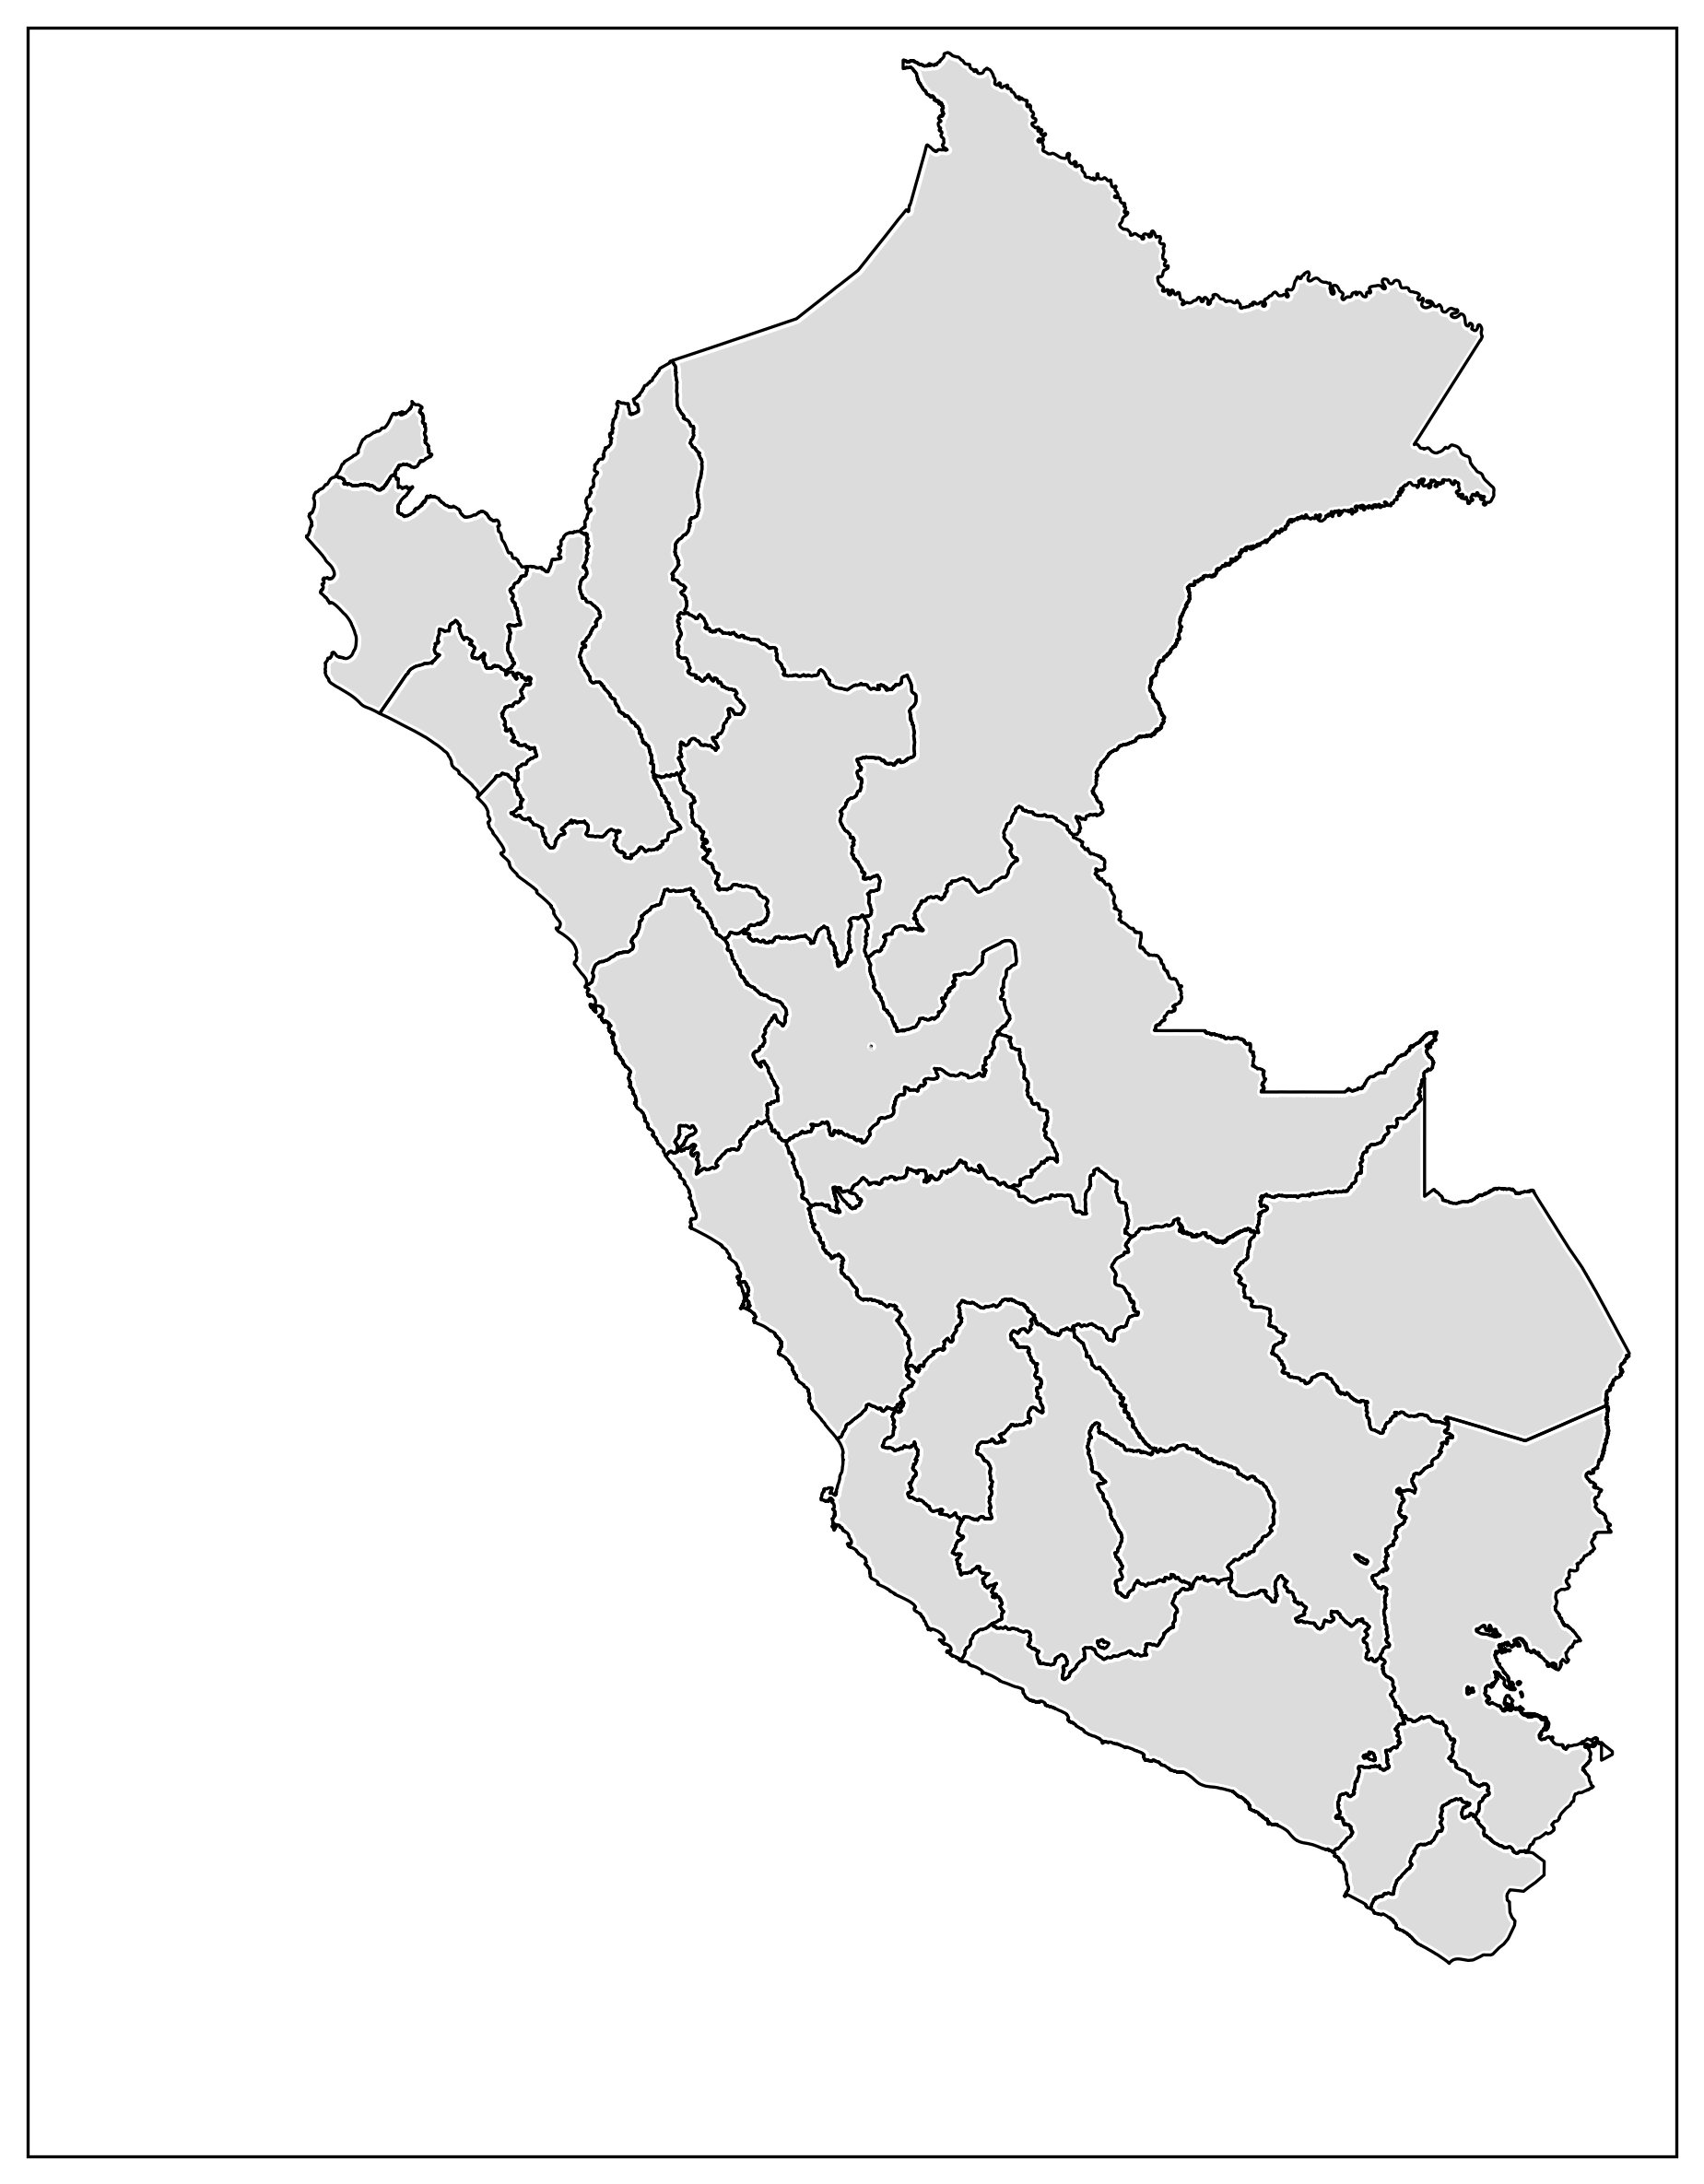

In [23]:
# ───────────────────── 6. FIGURA Y MAPA BASE ───────────────────
fig = plt.figure(figsize=(8, 10), dpi=300)
ax  = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-84, -68.2, -20.2, 0.2])

# relleno pastel + borde doble (halo blanco + línea negra)
for dep, geom in zip(gdf["NOMBDEP"], gdf.geometry):
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      # facecolor=fill_color[dep],
                      facecolor="gainsboro",     # <-- siempre el mismo
                      edgecolor="white",
                      linewidth=2.4, zorder=0)
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      facecolor="none",
                      edgecolor="black",
                      linewidth=0.8, zorder=1)

In [24]:
# ───────────────────── 7. ARCOS Y FLECHAS ──────────────────────
for _, r in df.iterrows():
    if r["ParentRegion"] not in coords or r["ChildRegion"] not in coords:
        continue

    # # Escala de separación entre flechas (ajusta si quieres más espacio)
    # offset_scale = (r["ruta_id"] - 1) * 0.1

    # Generar curva con desplazamiento
    seg = bezier(coords[r["ParentRegion"]], coords[r["ChildRegion"]])

    # Color según fecha
    col = sm.to_rgba(mdates.date2num(r["ParentDate"]))

    # Línea
    lc = LineCollection([seg], colors=[col], lw=1, alpha=0.5,
                        transform=ccrs.PlateCarree(), zorder=2)
    ax.add_collection(lc)

    # Flecha
    idx = int(0.7 * (len(seg) - 2))
    arrow = FancyArrowPatch(seg[idx], seg[idx+1], color=col,
                            mutation_scale=2, zorder=3,
                            transform=ccrs.PlateCarree())
    ax.add_patch(arrow)

In [25]:
# ───────────────────── 8. PUNTOS Y ETIQUETAS ───────────────────
FACE = (0.886, 0.290, 0.200, 0.8)  # naranja-rojo 80 %
for dep, (lon, lat) in coords.items():
    size_px = size_lut.get(dep, 80)
    circ = Circle((lon, lat), size_px/2200, facecolor=FACE,
                  edgecolor="white", lw=0.6, zorder=4,
                  transform=ccrs.PlateCarree())
    ax.add_patch(circ)

    offset = 0.15 if lat > -10 else -0.15
    ax.text(lon + 0.05, lat + offset, dep.title(),
            fontsize=8, ha="left", va="center", zorder=5,
            bbox=dict(facecolor="white", alpha=.7, pad=1, lw=0),
            transform=ccrs.PlateCarree())


In [26]:
# ───────────────────── 9. BARRA DE COLOR ───────────────────────
# cax = fig.add_axes([0.18, 0.06, 0.80, 0.03])
# 1) posición del eje del mapa en coordenadas de figura
map_bbox = ax.get_position()           # Bbox(x0, y0, x1, y1)

# 2) ancho que quieres para la barra (fracción de la figura)
cb_width  = 0.60                       # ejemplo: 60 % del ancho de la fig
cb_height = 0.02                       # grosor vertical (sin cambiar)

# 3) calcula la coordenada 'left' para centrarla bajo el mapa
left = map_bbox.x0 + (map_bbox.width - cb_width) / 2

# 4) crea (o recrea) el eje de la colorbar
bottom = 0.06                          # la distancia vertical que ya usabas
cax = fig.add_axes([left, bottom, cb_width, cb_height])
cb  = plt.colorbar(sm, cax=cax, orientation="horizontal")

# marcas mensuales, año solo en la primera
cb.ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
cb.ax.minorticks_off()
first_tick = cb.ax.get_xticks()[0]
# print(first_tick)
first_dt   = mdates.num2date(first_tick)
# print(first_dt)
def fmt(x, pos, first=first_dt):
    dt = mdates.num2date(x)
    return f"{dt:%b}\n{dt:%Y}" if (dt.month==first.month) else f"{dt:%b}"
# cb.ax.xaxis.set_major_formatter(mdates.FuncFormatter(fmt))
cb.ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(fmt)           #  ← usa mticker, no mdates
)
cb.ax.xaxis.set_label_position('top')
cb.set_label("Date", size=8, labelpad=4)
# rotar a 45° y alinear a la derecha
for lab in cb.ax.get_xticklabels():
    lab.set_rotation(0)
    lab.set_ha("center")         # ancla por la derecha para que no se solapen
    lab.set_va("top")        # verticalmente centrado
cb.ax.tick_params(axis="x", labelsize=5, pad=4, length=1)

# marco tenue para la barra
for spine in cb.ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.4)
    spine.set_color("#555")

<Figure size 640x480 with 0 Axes>

In [27]:
# ───────────────────── 10. ESCALA 200 km ───────────────────────
bar = AnchoredSizeBar(ax.transData, 1.2, '200 km', loc=3,
                      pad=0.6, color='black',
                      frameon=False, size_vertical=0.10)
ax.add_artist(bar)

In [28]:
# ───────────────────── 11. TÍTULO Y PIE ────────────────────────
plt.suptitle("Dispersión de linajes virales entre departamentos del Perú (2020-2024)",
             fontsize=13, fontweight='bold', y=0.988)
bbox = ax.get_position()
# caption = (
#     "Figura 1 | Arcos coloreados según la fecha origen del evento (ParentDate). Los círculos se escalan al número total de eventos registrados \n"
#     "como origen para cada departamento. El fondo muestra los límites administrativos proporcionados por el INEI."
# )
# Bbox(x0, y0, x1, y1)
# Opcional: envolver a ~90 caracteres para evitar líneas ultra-largas
# wrapped = "\n".join(textwrap.wrap(caption, 90))
# ── 3. Coordenadas del centro del mapa ─────────────────────────
# x_center = bbox.x0 + bbox.width / 2
# y_bottom = 0.01                # distancia vertical en fracción de figura
# ── 4. Dibujar texto centrado y con alineación adecuada ────────
# fig.text(
#     x_center, y_bottom,
#     caption,
#     ha="center", va="bottom",
#     fontsize=6.5,
#     wrap=True                  # Matplotlib ≥3.4 respeta saltos automáticos
# )

<Figure size 640x480 with 0 Axes>

In [29]:
# ───────────────────── 12. GUARDAR Y MOSTRAR ───────────────────
fig.savefig("../output/Movimientos_Departamentales_Peru_año.png", dpi=300, bbox_inches="tight")
plt.show()